In [1]:
import xarray as xr
import os
import netCDF4
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # download data from huggingface
# from huggingface_hub import hf_hub_download
# from huggingface_hub import snapshot_download
# from huggingface_hub import hf_hub_url
# snapshot_download(repo_id="LEAP/ClimSim_low-res",
#                   repo_type="dataset",
#                local_dir="F:/phd/L96_demo-main/notebooks/climsim_data/train",
#                   allow_patterns='train/0009-01/*.nc',
#                  local_dir_use_symlinks=False)

# combine mli (mlo) data to one nc file
## 0001-02 one month data

In [2]:
# from os import listdir
# from os.path import isfile, join

# mypath = r'F:\phd\L96_demo-main\notebooks\climsim_data\train\0008-02'
# # allfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# allfiles = []
# for path, subdirs, files in os.walk(mypath):
#     for name in files:
#        allfiles.append(os.path.join(path, name))
# print(len(allfiles))

# mli_files = []
# mlo_files = []

# for i in range(len(allfiles)):
#     if 'mli' in allfiles[i]:
#         mli_files.append(allfiles[i])
#     if 'mlo' in allfiles[i]:
#         mlo_files.append(allfiles[i])

# ds_mli = []
# ds_mlo = []

# for i in range(len(mli_files)):
#     ds_mli.append(xr.open_dataset(mli_files[i]).expand_dims('time'))
# for i in range(len(mlo_files)):
#     ds_mlo.append(xr.open_dataset(mlo_files[i]).expand_dims('time'))

# combined_mli = xr.concat(ds_mli, dim='time').to_netcdf(mypath + '0008-02_mli.nc')
# combined_mlo = xr.concat(ds_mlo, dim='time').to_netcdf(mypath + '0008-02_mlo.nc')

# preprocessing

In [3]:
mli = xr.open_dataset('F:/phd/L96_demo-main/notebooks/climsim_data/train/0008-02/0008-02_mli.nc')
mlo = xr.open_dataset('F:/phd/L96_demo-main/notebooks/climsim_data/train/0008-02/0008-02_mlo.nc')

In [4]:
mli

<xarray.Dataset>
Dimensions:           (time: 2016, ncol: 384, lev: 60)
Dimensions without coordinates: time, ncol, lev
Data variables: (12/29)
    ymd               (time) int32 ...
    tod               (time) int32 ...
    cam_in_ALDIF      (time, ncol) float64 ...
    cam_in_ALDIR      (time, ncol) float64 ...
    cam_in_ASDIF      (time, ncol) float64 ...
    cam_in_ASDIR      (time, ncol) float64 ...
    ...                ...
    state_t           (time, lev, ncol) float64 ...
    state_u           (time, lev, ncol) float64 ...
    state_v           (time, lev, ncol) float64 ...
    pbuf_CH4          (time, lev, ncol) float64 ...
    pbuf_N2O          (time, lev, ncol) float64 ...
    pbuf_ozone        (time, lev, ncol) float64 ...
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP

In [5]:
# fix time index

date = []
for i in range(len(mli.ymd.values)):
    my_str=str(mli.ymd.values[i])
    date.append(my_str[:0] + '200' + my_str[0:])

mli['time'] = pd.to_datetime(date) + pd.to_timedelta(mli.tod.values, unit='s')
mlo['time'] = pd.to_datetime(date) + pd.to_timedelta(mlo.tod.values, unit='s')

In [6]:
# downsample data every 7 samples, data frequency is 1200s.
# mli = mli.resample(time='8400S').mean()
# mlo = mlo.resample(time='8400S').mean()
mli = mli.isel(time=slice(None,None,7))
mlo = mlo.isel(time=slice(None,None,7))

In [7]:
mlo

<xarray.Dataset>
Dimensions:         (time: 288, ncol: 384, lev: 60)
Coordinates:
  * time            (time) datetime64[ns] 2008-02-01 ... 2008-02-28T21:40:00
Dimensions without coordinates: ncol, lev
Data variables: (12/16)
    ymd             (time) int32 ...
    tod             (time) int32 0 8400 16800 25200 ... 52800 61200 69600 78000
    cam_out_FLWDS   (time, ncol) float64 ...
    cam_out_NETSW   (time, ncol) float64 ...
    cam_out_PRECC   (time, ncol) float64 ...
    cam_out_PRECSC  (time, ncol) float64 ...
    ...              ...
    state_q0001     (time, lev, ncol) float64 ...
    state_q0002     (time, lev, ncol) float64 ...
    state_q0003     (time, lev, ncol) float64 ...
    state_t         (time, lev, ncol) float64 ...
    state_u         (time, lev, ncol) float64 ...
    state_v         (time, lev, ncol) float64 ...
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP

In [8]:
# in/out variable lists (6:10)
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

# nc to numpy to tensor, then reshape
input_list = []
output_list = []

for i in range(len(vars_mli)):
    if i < 2:
        temp=torch.Tensor(mli[vars_mli[i]].to_numpy())
        new_var=temp.reshape(temp.shape[0] * temp.shape[2], temp.shape[1])
        input_list.append(new_var)
    else:
        temp=torch.Tensor(mli[vars_mli[i]].to_numpy())
        new_var=temp.reshape(temp.shape[0] * temp.shape[1], 1)
        input_list.append(new_var)

# calculate heating and moistening tendency.
ptend_t = (mlo['state_t'] - mli['state_t']) / 1200
ptend_q0001 = (mlo['state_q0001'] - mli['state_q0001']) / 1200
# add to output list
output_list.extend([ptend_t,ptend_q0001])

for i in range(len(vars_mlo)):
    if i < 2:
        temp=torch.Tensor(output_list[i].to_numpy())
        new_var=temp.reshape(temp.shape[0] * temp.shape[2], temp.shape[1])
        output_list[i] = new_var
    if i >= 2:
        temp=torch.Tensor(mlo[vars_mlo[i]].to_numpy())
        new_var=temp.reshape(temp.shape[0] * temp.shape[1], 1)
        output_list.append(new_var)

In [9]:
# calc normalization

for i in range(len(input_list)):
    if i < 2:
        input_list[i] = (input_list[i] - input_list[i].mean(dim=0)) / (input_list[i].max(dim=0)[0] - input_list[i].min(dim=0)[0])  
    else:
        input_list[i] = (input_list[i] - input_list[i].mean()) / (input_list[i].max() - input_list[i].min())  

## no normalization for y
# for i in range(len(output_list)):
#     if i < 2:
#         output_list[i] = (output_list[i] - output_list[i].mean(dim=0)) / (output_list[i].max(dim=0)[0] - output_list[i].min(dim=0)[0])  
#     else:
#         output_list[i] = (output_list[i] - output_list[i].mean()) / (output_list[i].max() - output_list[i].min())  


In [10]:
# concat
input = torch.cat((input_list[0],input_list[1],input_list[2],input_list[3],input_list[4],input_list[5]), dim=1)
output = torch.cat((output_list[0],output_list[1],output_list[2],output_list[3],output_list[4],output_list[5],output_list[6],output_list[7],output_list[8],output_list[9]), dim=1)

print(input.shape,output.shape)
# unsample data: 774144 = 28 * 72 * 384

torch.Size([110592, 124]) torch.Size([110592, 128])


# test input data with theirs (val:0008-02 to 0009-01)

In [11]:
X=np.load('climsim_data/val_input.npy')

In [12]:
X[0,:]

array([-2.1913459e-03, -1.7944887e-02, -4.5234229e-02, -1.8812425e-02,
        1.2241836e-03,  5.4736424e-02,  7.9991966e-02,  6.6402398e-02,
        6.1990730e-02,  6.2253091e-02,  5.1185194e-02,  4.6816483e-02,
        4.8013736e-02,  4.2244118e-02,  1.9963728e-02, -1.1743228e-02,
       -1.6514115e-02, -3.1537268e-02, -7.3459931e-02, -8.7187998e-02,
       -9.5602296e-02, -6.7409396e-02, -2.5630416e-02,  1.4921249e-02,
        4.1257340e-02,  5.6141108e-02,  6.2658504e-02,  6.4611822e-02,
        6.6882201e-02,  6.7682333e-02,  6.9309019e-02,  7.5467244e-02,
        8.1024468e-02,  8.4922343e-02,  8.7200657e-02,  8.7108433e-02,
        8.9283474e-02,  9.1625057e-02,  9.4715320e-02,  9.5724754e-02,
        9.7043157e-02,  9.8063178e-02,  9.7116463e-02,  9.8507255e-02,
        9.8593235e-02,  9.7905174e-02,  9.5312789e-02,  9.1622062e-02,
        8.7270044e-02,  8.4584579e-02,  8.3577700e-02,  8.3638921e-02,
        8.3342053e-02,  8.2297072e-02,  8.0700077e-02,  7.8771718e-02,
      

In [13]:
input[0,:]

tensor([-0.2637, -0.2625, -0.2419, -0.2554, -0.2591, -0.2390, -0.2602, -0.2596,
        -0.2267, -0.2322, -0.2590, -0.2720, -0.2378, -0.2306, -0.2427, -0.2215,
        -0.2075, -0.2185, -0.1864, -0.2060, -0.2334, -0.2482, -0.2200, -0.2220,
        -0.2662, -0.2627, -0.2398, -0.2456, -0.2419, -0.2259, -0.2423, -0.2251,
        -0.2161, -0.2480, -0.2164, -0.2353, -0.2450, -0.2291, -0.2508, -0.2391,
        -0.2417, -0.2382, -0.2342, -0.2265, -0.2462, -0.2439, -0.2218, -0.2302,
        -0.2311, -0.2326, -0.2213, -0.2099, -0.2349, -0.2349, -0.1971, -0.2088,
        -0.2302, -0.2248, -0.2290, -0.2196, -0.1274, -0.1278, -0.1239, -0.1268,
        -0.1302, -0.1290, -0.1259, -0.1240, -0.1234, -0.1218, -0.1197, -0.1169,
        -0.1315, -0.1278, -0.1248, -0.1242, -0.1310, -0.1313, -0.1253, -0.1240,
        -0.1284, -0.1274, -0.1219, -0.1222, -0.1319, -0.1277, -0.1314, -0.1335,
        -0.1333, -0.1297, -0.1325, -0.1290, -0.1265, -0.1244, -0.1188, -0.1162,
        -0.1283, -0.1270, -0.1240, -0.12

# .npy data: NN
## to test an ML model, using the prepared train_input and train_target datasets is an easier way, I choose val instead due to the size of data.

In [14]:
X=np.load('climsim_data/val_input.npy')
y=np.load('climsim_data/val_target.npy')

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [15]:
X.shape
# 365 * 72 * 384 / 7 = 1441645.7

torch.Size([1441920, 124])

In [16]:
LEARNING_RATE = 0.01
IN_FEATURES = 124
OUT_FEATURES = 128
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [17]:
y_train.shape

torch.Size([1153536, 128])

In [18]:
class FCNN(nn.Module):
    def __init__(self, IN_FEATURES, hidden_dim, OUT_FEATURES):
        super().__init__()
        self.linear1 = nn.Linear(IN_FEATURES, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, OUT_FEATURES)
    def forward(self,x):
        return self.linear2(self.relu(self.linear1(x)))
        
model = FCNN(IN_FEATURES,64,OUT_FEATURES)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [19]:
torch.manual_seed(42)
epochs = 300

for epoch in range(epochs):

    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.049921225756406784 | Test loss: 0.04235820099711418
Epoch: 50 | Train loss: 0.005977715365588665 | Test loss: 0.005957366432994604
Epoch: 100 | Train loss: 0.005493566859513521 | Test loss: 0.005514870397746563
Epoch: 150 | Train loss: 0.005315355956554413 | Test loss: 0.005321037489920855
Epoch: 200 | Train loss: 0.005206403788179159 | Test loss: 0.005214393138885498
Epoch: 250 | Train loss: 0.0051278346218168736 | Test loss: 0.005135661456733942


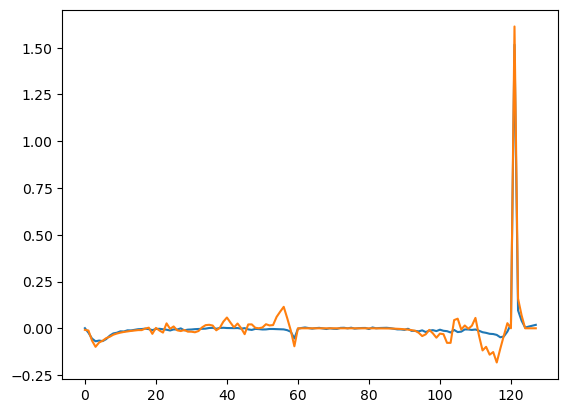

In [20]:
plt.plot(test_pred[0,:])
plt.plot(y_test[0,:])

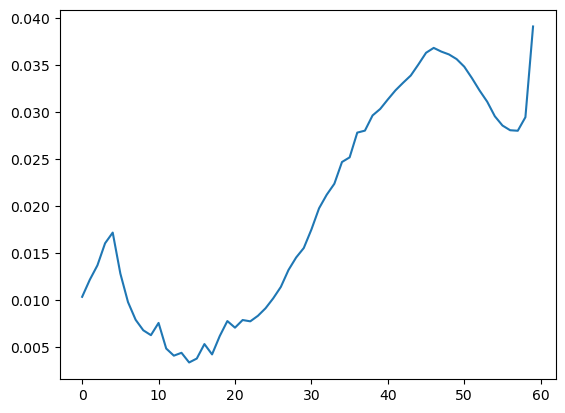

In [21]:
# Figure 2 in paper: error for different variables example: heating tendency

y_test = y_test.detach().numpy()
test_pred = test_pred.detach().numpy()

test_ptend_t = y_test[:,:60]
pred_ptend_t = test_pred[:,:60]

plt.plot(np.mean(np.abs(test_ptend_t - pred_ptend_t), axis=0))


# .npy data Transformer

In [2]:
X=np.load('climsim_data/val_input.npy')
y=np.load('climsim_data/val_target.npy')

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [3]:
LEARNING_RATE = 0.01
IN_FEATURES = 124
OUT_FEATURES = 128
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)

In [4]:
# Setup data loaders for batch
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [6]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=124, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 128)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel()

D:\Anaconda3\envs\L96\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 10
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch   
        x_batch, y_batch = x_batch, y_batch
        optimizer.zero_grad()
        outputs = model(x_batch)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch, y_batch
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} Test loss: {val_losses[0]}")
    # model.eval()
    # with torch.inference_mode():
    #     test_pred = model(X_test)
    #     test_loss = loss_fn(test_pred, y_test)




Epoch: 0 Test loss: 0.013408709317445755


KeyboardInterrupt: 

In [8]:
len(val_losses)
# 288384 / 32 = 9012

9012

In [9]:
val_losses[0]

0.013408709317445755